In [1]:
import os
import pickle

import torch
import numpy as np
import pandas as pd
import sciplots as plots
from scipy.optimize import curve_fit

from src.utils.data import DarkDataset
from src.utils import plot_config, analysis
from src.utils.utils import open_config, ROOT, tests_format

In [3]:
_, config = open_config('main', os.path.join(ROOT, '../config.yaml'))

states_dir = config['output']['network-states-directory']
plots_dir = os.path.join(ROOT, config['output']['plots-directory'], 'final_plots')
x_data = np.concat((
    np.arange(1, 10),
    np.arange(10, 22, 2),
    [50, 100, 1000],
))

In [4]:
dataset = DarkDataset(
    config['data']['data-dir'],
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        'darkskies_cdm',
        'darkskies_0.1',
        'darkskies_0.2',
    ],
    [],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
dataset.high_dim.shape

(25200, 3, 100, 100)

In [7]:
name = 'test_latent_1'

with open(os.path.join(ROOT, f'../data/{name}.pkl'), 'rb') as file:
    data = pickle.load(file)

data['net'] = np.empty_like(data['net_path'], dtype=object)

if isinstance(data['net_path'].iloc[0], str):
    for i, net_path in enumerate(data['net_path']):
        data.loc[i, 'net'] = torch.load(net_path, map_location='cpu')
else:
    data['net'] = data['net_path']

In [ ]:
nets = tests_format('net', data)
accuracy = tests_format('accuracy', data).astype(float)
nets.shape, accuracy.shape

In [5]:
name = 'test_latent_2'

with open(os.path.join(ROOT, f'../data/{name}.pkl'), 'rb') as file:
    data = pickle.load(file)

data['net'] = np.empty_like(data['net_path'], dtype=object)

if isinstance(data['net_path'].iloc[0], str):
    for i, net_path in enumerate(data['net_path']):
        data.loc[i, 'net'] = torch.load(net_path, map_location='cpu')
else:
    data['net'] = data['net_path']

In [8]:
nets = np.concat((tests_format('net', data), nets))
accuracy = np.concat((tests_format('accuracy', data).astype(float), accuracy))
nets.shape, accuracy.shape

((6, 18, 5), (6, 18, 5))

In [121]:
with open(os.path.join(ROOT, f'../data/temp_{name}_predictions.pkl'), 'rb') as file:
    predictions = pickle.load(file)

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    nets,
    dataset,
)

In [73]:
with open(os.path.join(ROOT, f'../data/temp_{name}_predictions.pkl'), 'wb') as file:
    pickle.dump(predictions, file)

In [105]:
accuracies = np.empty(predictions.shape)
sim_sets = [
    ['bahamas_cdm', 'bahamas_0.1', 'bahamas_0.3', 'bahamas_1'],
    ['bahamas_cdm_low', 'bahamas_cdm_hi'],
    ['darkskies_cdm', 'darkskies_0.1', 'darkskies_0.2'],
]

for shape in np.ndindex(predictions.shape):
    idxs = np.isin(dataset.extra['sims'].iloc[predictions[*shape]['ids']], sim_sets[shape[0]])
    accuracies[*shape] = np.count_nonzero(predictions[*shape]['preds'][idxs] == predictions[*shape]['targets'].flatten()[idxs]) / np.count_nonzero(idxs)

mean_accuracies = np.mean(accuracies, axis=-1)
ste_accuracies = np.std(accuracies, axis=-1, ddof=1 if predictions.shape[-1] > 1 else 0) / np.sqrt(accuracies.shape[-1])
mean_accuracies.shape, ste_accuracies.shape

((4, 8), (4, 8))

In [9]:
mean_accuracies = np.mean(accuracy, axis=-1)
ste_accuracies = np.std(accuracy, axis=-1, ddof=1 if accuracy.shape[-1] > 1 else 0) / np.sqrt(accuracy.shape[-1])
mean_accuracies.shape, ste_accuracies.shape

((6, 18), (6, 18))

In [10]:
red_x_data = x_data[:-1]
red_mean_accuracies = mean_accuracies[..., :-1]
red_ste_accuracies = ste_accuracies[..., :-1]

In [11]:
def arctan_fit(x, a, b, c):
    return a + np.arctan((x - b) / c)

def inv_arctan_fit(y, a, b, c):
    return np.tan(y - a) * c + b

popts = []
pcovs = []
model_means = []
model_x_data = 10 ** np.linspace(np.log10(red_x_data[0]), np.log10(red_x_data[-1]), 1000)

for mean_accuracy, ste_accuracy in zip(red_mean_accuracies, red_ste_accuracies):
    popt, pcov = curve_fit(
        arctan_fit,
        red_x_data,
        mean_accuracy,
        sigma=ste_accuracy,
        p0=[0, 0, 1],
        maxfev=int(1e4),
    )
    popts.append(popt)
    pcovs.append(pcov)
    model_means.append(arctan_fit(model_x_data, *popt))
    print(f'Max Accuracy: {np.max(mean_accuracy):.2%} +/- {np.max(ste_accuracy):.2%}\tAsymptotic Accuracy: {arctan_fit(6, *popt):.2%}')

popts = np.array(popts)
pcovs = np.array(pcovs)
popts_unc = np.sqrt(np.diagonal(pcovs, axis1=1, axis2=2))
model_means = np.array(model_means)
model_means.shape, popts.shape, pcovs.shape

Max Accuracy: 64.03% +/- 0.71%	Asymptotic Accuracy: 63.22%
Max Accuracy: 60.94% +/- 0.48%	Asymptotic Accuracy: 60.50%
Max Accuracy: 60.03% +/- 0.72%	Asymptotic Accuracy: 59.35%
Max Accuracy: 64.53% +/- 0.56%	Asymptotic Accuracy: 63.46%
Max Accuracy: 47.95% +/- 0.53%	Asymptotic Accuracy: 47.09%
Max Accuracy: 48.92% +/- 0.52%	Asymptotic Accuracy: 48.05%


((6, 1000), (6, 3), (6, 3, 3))

In [71]:
sigmas = np.sqrt(np.diagonal(pcovs, axis1=1, axis2=2))
pd.DataFrame(
    np.stack((popts, sigmas), axis=-1).reshape(-1, 6),
    columns=['a', '+/-', 'b', '+/-', 'c', '+/-'],
    index=['BAHAMAS X-Rays', '+ BAHAMAS-AGN X-Rays', '+ DARKSKIES X-Rays', 'BAHAMAS', '+ BAHAMAS-AGN', '+ DARKSKIES'],
).round(4)

,a,+/-,b,+/-,c,+/-
BAHAMAS X-Rays,-0.9359,0.0028,0.1735,1.0666,0.0155,0.0195
+ BAHAMAS-AGN X-Rays,-0.9623,0.0011,0.8800,0.0209,0.0178,0.0032
+ DARKSKIES X-Rays,-0.9712,0.0009,0.7846,0.0334,0.0315,0.0044
BAHAMAS,-0.9357,0.0016,0.7378,0.8226,0.0025,0.0081
+ BAHAMAS-AGN,-1.0985,0.0013,0.8262,0.1832,0.0072,0.0076
+ DARKSKIES,-1.0793,0.0012,0.5480,0.0396,0.0602,0.0054


In [38]:
np.sqrt(
    popts[:, -1] ** 2 * popts_unc[:, 0] ** 2 * (np.tan(popts[:, 0] - 0.98 * model_means[:, -1]) ** 2 + 1) ** 2 +
    popts_unc[:, 1] ** 2 +
    popts_unc[:, 2] ** 2 * np.tan(popts[:, 0] - 0.98 * model_means[:, -1]) ** 2,
)

array([1.87149776, 0.28712574, 0.41095602, 1.03802988, 0.82832975,
       0.82675997])

In [72]:
pd.DataFrame([np.round(inv_arctan_fit(0.98 * model_means[:, -1], *popts.swapaxes(0, 1)), 2)[[3, 4, 5, 0, 1, 2]]], columns=['BAHAMAS', '+BAHAMAS-AGN', '+DARKSKIES', 'BAHAMAS X', '+BAHAMAS-AGN X', '+DARKSKIES X'])

,BAHAMAS,+BAHAMAS-AGN,+DARKSKIES,BAHAMAS X,+BAHAMAS-AGN X,+DARKSKIES X
0,0.94,1.58,6.33,1.38,2.32,3.34


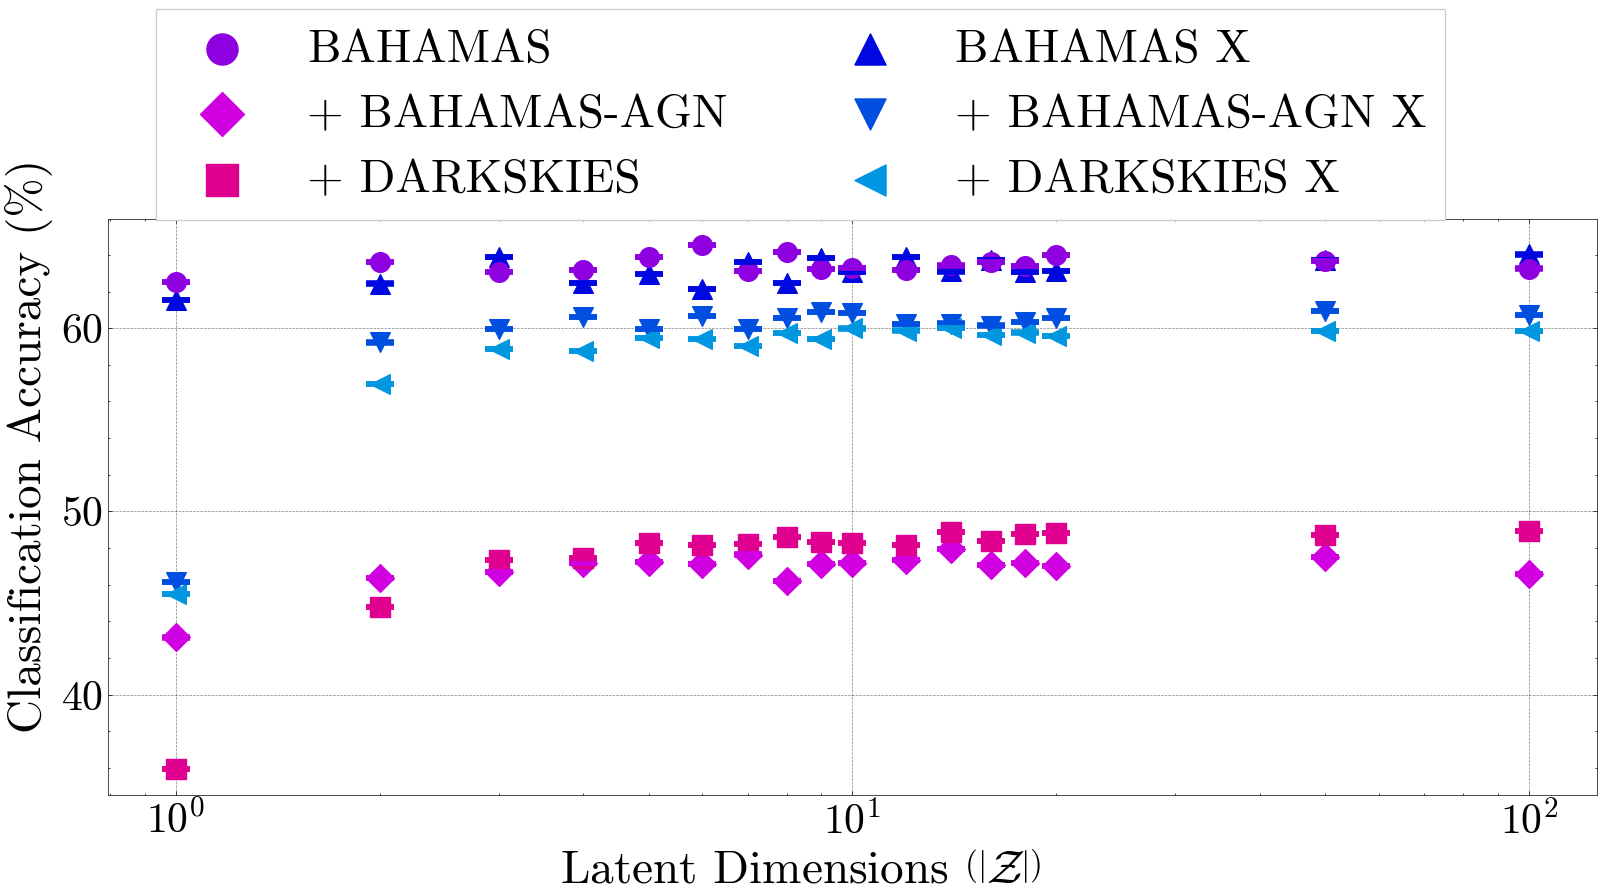

In [76]:
plot = plots.PlotPlots(
    red_x_data,
    red_mean_accuracies * 100,
    log_x=True,
    x_label=r'Latent Dimensions $\left(\left|\mathcal{Z}\right|\right)$',
    y_label='Classification Accuracy (%)',
    styles=['^', 'v', '<', 'o', 'D', 's'],
    labels=['BAHAMAS X', '+ BAHAMAS-AGN X', '+ DARKSKIES X', 'BAHAMAS', '+ BAHAMAS-AGN', '+ DARKSKIES'],
    y_error=red_ste_accuracies,
    # colours=plot_config.BAHAMAS[2:3] + plot_config.BAHAMAS_AGN[:1] + plot_config.FLAMINGO_TEST,
    colours=plot_config.BAHAMAS[:3] + plot_config.DARKSKIES[:3],
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    label_permute=[3, 4, 5, 0, 1, 2],
    cap_size=10,
    line_width=4,
    eline_width=4,
    alpha_marker=1,
)
plot.set_axes_pad(0.05)

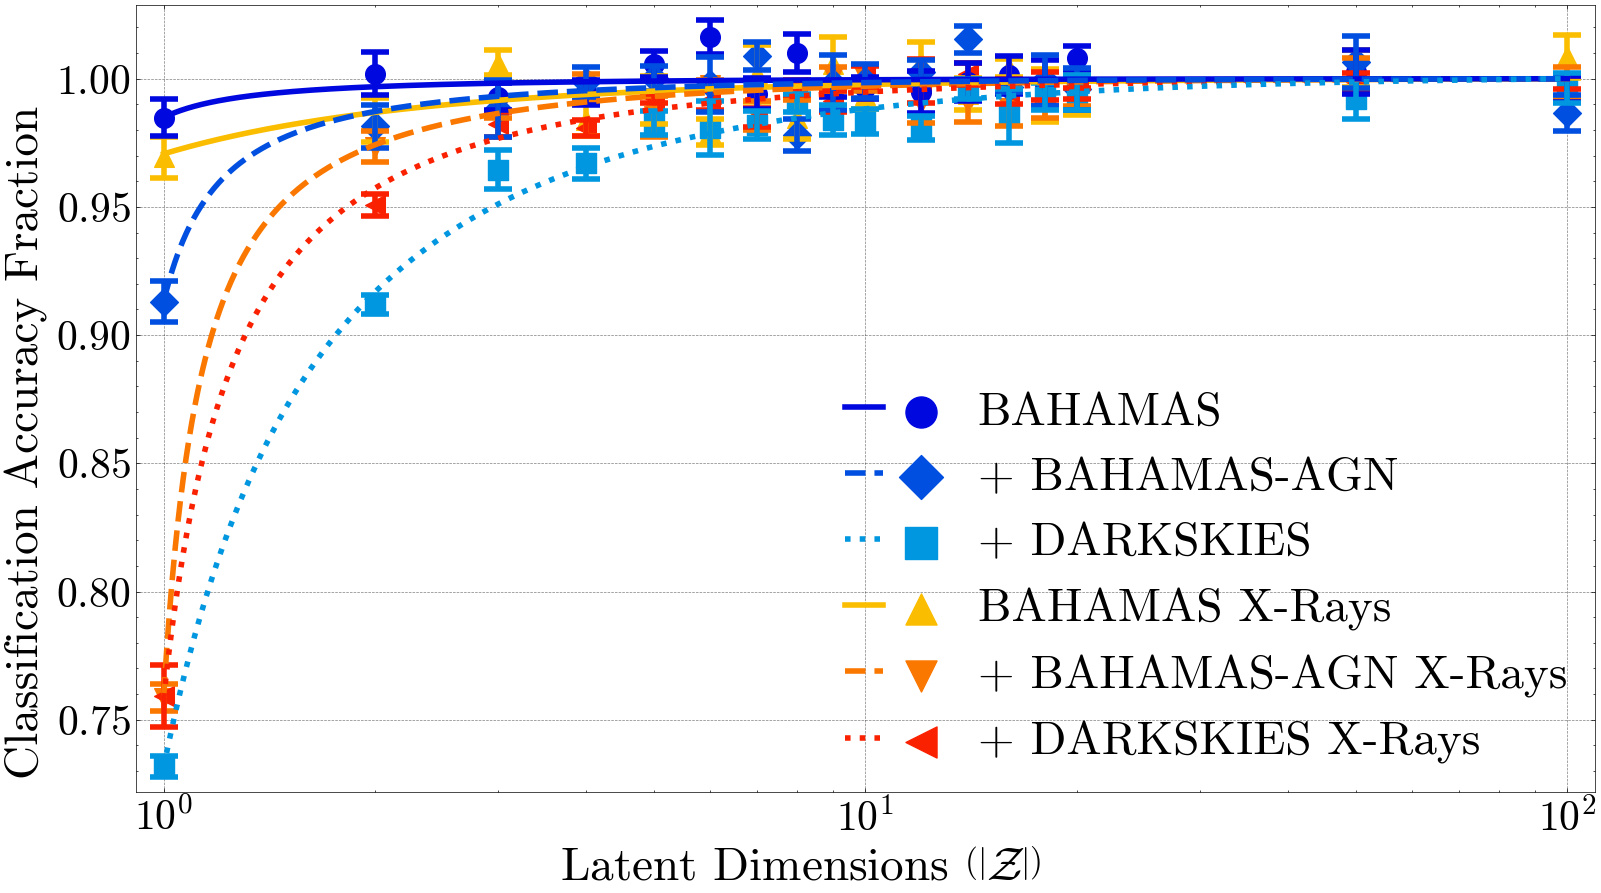

In [66]:
slice_ = slice(None)
idxs = slice(3)
plot = plots.PlotPlots(
    [red_x_data] * len(red_mean_accuracies[slice_]) + [model_x_data] * len(red_mean_accuracies[slice_]),
    # [*loss_means[slice_, :, 0] * 100, *model_means[slice_] * 100],
    [*(red_mean_accuracies / model_means[:, -1:])[slice_], *(model_means / model_means[:, -1:])[slice_]],
    # [
    #     *((loss_means[..., 0] - model_means[:, :1]) / (model_means[:, -1:] - model_means[:, :1]))[slice_],
    #     *((model_means - model_means[:, :1]) / (model_means[:, -1:] - model_means[:, :1]))[slice_],
    # ],
    log_x=True,
    x_label=r'Latent Dimensions $\left(\left|\mathcal{Z}\right|\right)$',
    # y_label='Classification Accuracy (%)',
    y_label='Classification Accuracy Fraction',
    # styles=['o', '^', 's', '*'][idxs] + ['-', '--', ':', '-.'][idxs],
    styles=['^', 'v', '<', 'o', 'D', 's'] + ['-', '--', ':', '-', '--', ':'],
    # labels=['BAHAMAS', '+ BAHAMAS-AGN', '+ DARKSKIES', '+ FLAMINGO', '+ TNG'][slice_] * 2,
    # labels=['BAHAMAS', '+ BAHAMAS-AGN', '+ DARKSKIES', '+ FLAMINGO'][slice_][idxs] * 2,
    labels=['BAHAMAS X-Rays', '+ BAHAMAS-AGN X-Rays', '+ DARKSKIES X-Rays', 'BAHAMAS', '+ BAHAMAS-AGN', '+ DARKSKIES'] * 2,
    # y_error=[*loss_stes[slice_, :, 0] * 100, *[None] * len(loss_means[slice_])],
    # y_error=[*(loss_stes[..., 0] / (model_means[:, -1:] - model_means[:, :1]))[slice_], *[None] * len(loss_means[slice_])],
    y_error=[*(red_ste_accuracies / model_means[:, -1:])[slice_], *[None] * len(red_mean_accuracies[slice_])],
    # colours=(plot_config.BAHAMAS[2:3] + plot_config.BAHAMAS_AGN[:1] + plot_config.FLAMINGO_TEST +
    #          plot_config.FLAMINGO[:1] + plot_config.FLAMINGO[-1:])[slice_][idxs] * 2,
    colours=(plot_config.FLAMINGO[:3] + plot_config.BAHAMAS[:3]) * 2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    label_permute=[3, 4, 5, 0, 1, 2],
    cap_size=10,
    line_width=4,
    eline_width=4,
    alpha_marker=1,
    axis=True,
    markers=True,
    frameon=False,
    cols=1,
    loc='lower right'
)
plot.set_axes_pad(0.02)
plot.savefig(plots_dir, name='latent_dim_optimisation')